In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIRECTORY = 'drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_09/'

In [ ]:
!cp drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_09/*.txt .

In [ ]:
!nvidia-smi

Fri May 14 18:32:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Семинар 10: "Генерация текстов"

ФИО: 

In [ ]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [ ]:
lines = [
    x.split('\t')[1].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]
lines = [l.lower().replace(".", "").replace(",", "").replace("?", "").replace("!", "").replace("'", " ").split() for l in lines if l != ""]

In [ ]:
lines[3]

['organizing',
 'is',
 'what',
 'you',
 'do',
 'before',
 'you',
 'do',
 'something',
 'so',
 'that',
 'when',
 'you',
 'do',
 'it',
 'it',
 'is',
 'not',
 'all',
 'mixed',
 'up']

In [ ]:
# [(len(l), l) for l in sorted(lines, key=len)]

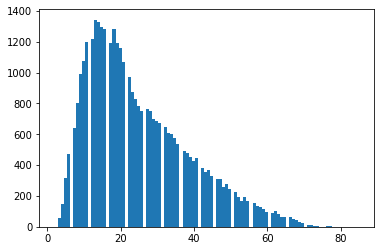

In [ ]:
plt.hist(list(map(len, lines)), bins=100);

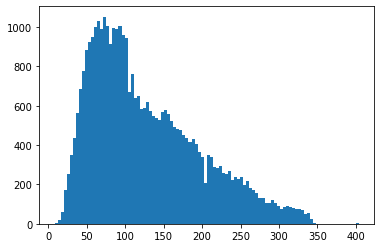

In [ ]:
plt.hist(list(map(lambda x: len(' '.join(x)), lines)), bins=100);

In [ ]:
line = lines[0]

In [ ]:
line

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [ ]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [ ]:
np.random.seed(777)
torch.manual_seed(777)

In [ ]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters)) + ['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [ ]:
vocab = Vocabulary(lines)

In [ ]:
assert vocab.decode(vocab.encode(lines[0])).split() == lines[0]

In [ ]:
len(lines)

36165

In [ ]:
len(vocab.char_to_id)

30358

In [ ]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go] + tokens)
        _output = np.array(tokens + [self.eos])
        return _input, _output

In [ ]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [ ]:
dataset = Quotes(lines, vocab)

In [ ]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [ ]:
for el in dataloader:
    print(el)
    break

(tensor([[30357, 13409, 12594,  ...,   889, 15170, 16733],
        [30357, 30273,  2718,  ...,     0,     0,     0],
        [30357, 29664, 13409,  ...,     0,     0,     0],
        ...,
        [30357, 13483, 18393,  ...,     0,     0,     0],
        [30357, 29376, 30071,  ...,     0,     0,     0],
        [30357,  1141,  1083,  ...,     0,     0,     0]]), tensor([[13409, 12594, 27211,  ..., 15170, 16733, 30356],
        [30273,  2718, 20063,  ...,     0,     0,     0],
        [29664, 13409, 10283,  ...,     0,     0,     0],
        ...,
        [13483, 18393, 24481,  ...,     0,     0,     0],
        [29376, 30071,  9133,  ...,     0,     0,     0],
        [ 1141,  1083, 13238,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), array([64, 61, 58, 56, 51, 50, 48, 48, 45, 43, 41, 38,

In [ ]:
import gensim.downloader

#w2v = gensim.downloader.load('word2vec-google-news-300')
w2v = gensim.downloader.load('glove-twitter-25')

matrix = []
for w_id in tqdm(range(len(vocab.id_to_char))):
     word = vocab.id_to_char[w_id]
     if word not in w2v:
       emb = w2v["_"]
     else:
       emb = w2v[word]

     matrix.append(emb)

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
w2v.most_similar("good")

[('too', 0.9648016095161438),
 ('day', 0.9533665180206299),
 ('well', 0.9503172039985657),
 ('nice', 0.9438973069190979),
 ('better', 0.9425961375236511),
 ('fun', 0.9418926239013672),
 ('much', 0.9413353204727173),
 ('this', 0.9387556314468384),
 ('hope', 0.9383507370948792),
 ('great', 0.9378515481948853)]

### Часть 2: определение модели

In [ ]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

class OracleW2V(Oracle):
    def __init__(self, embeddings,
                 hidden_size=256,                 
                 layers=2):    
        nn.Module.__init__(self)

        embedding_size = embeddings.shape[1]
        vocabulary_size = embeddings.shape[0]

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings))
        for param in self.embedding.parameters():
            param.requires_grad = False

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )

        self.project = nn.Linear(
            hidden_size, embedding_size
        )     

        self.classify = nn.Linear(
            embedding_size, vocabulary_size
        )

        self.classifier = nn.Sequential(self.project, self.classify)

        with torch.no_grad():
            self.classify.weight.copy_(torch.from_numpy(embeddings))
        self.classify.weight.requires_grad = False

In [ ]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

In [ ]:
oracle = OracleW2V(np.array(matrix), hidden_size=64)

### Часть 3: обучение модели

In [ ]:
# optimizer = torch.optim.RMSprop(
#    oracle.parameters(), lr=0.001, weight_decay=1e-5
# )

optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [ ]:
losses = []

In [ ]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Epoch: 4


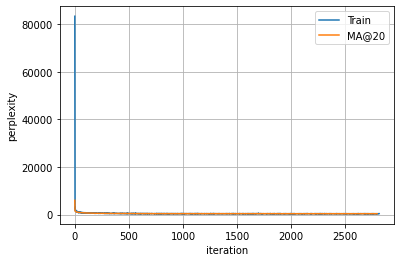

In [ ]:
oracle.cuda()

try:
    for epoch in range(5):
        for i, batch in enumerate(
                tqdm(dataloader, total=len(dataloader))
        ):
            (go, eos, mask) = map(lambda x: x.cuda(), batch[:-1])
            length = batch[-1]
            oracle.zero_grad()
            prediction = oracle(
                go, length
            ).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos) * mask.float()).sum()
            loss = loss / mask.sum()
            loss.backward()

            # [x.grad.clamp_(-1, 1) for x in oracle.parameters()]

            optimizer.step()
            losses.append(np.exp(loss.cpu().item()))
            if i % 50 == 0:
                clear_output(True)
                print('Epoch:', epoch, 'Loss:', losses[-1])
                plt.plot(losses, label='Train')
                plt.plot(moving_average(losses), label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()
except KeyboardInterrupt:
    pass
finally:
    oracle.cpu();

### Часть 4: оценивание модели

In [ ]:
for _ in range(25):
    print(oracle.generate(vocab))
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


the person and unhappy respect with the consensus of your more confidence <eos> 

is to men with toward every than things that are i able to tapping own secrets <eos> 

i know people will be awhile at of earth what know who to <eos> 

i know their unalienable she never i songwriter just had a fake that the athlete could if and never 

person in out fall to sleep to come being and new defined from all show and just day i who a substance 

of a goalkeeper poverty for if over you so world all of that wearing <eos> 

i i <eos> 

they snakes you lady you like is i will we have get play scala arteries man in black the defense one 

neighbors are spend a disturbed intellectual when i re never become to don t like behaving in at to 

was the played shooting sport fame fact time i one of these <eos> 

forms a pick both the sign it much cages like friends out from the little at years did superstition; 

relationships is out within us life theory and are people i die and like <eos> 

that may ten

<i> Приведите примеры сгенерированных предложений </i>

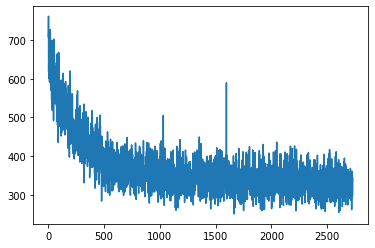

In [ ]:
plt.plot(losses[100:])

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [ ]:
class LSTMOracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(LSTMOracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = (Variable(torch.zeros(self.layers, 1, self.hidden_size)),
             Variable(torch.zeros(self.layers, 1, self.hidden_size)))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            # token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

In [ ]:
train_size = int(len(lines) * 0.67)
test_size = len(lines) - train_size

train_dataset = Quotes(lines[:train_size], vocab)
test_dataset = Quotes(lines[train_size:], vocab)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

In [ ]:
oracle = LSTMOracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

In [ ]:
# optimizer = torch.optim.RMSprop(
#    oracle.parameters(), lr=0.001, weight_decay=1e-5
# )

optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [ ]:
train_losses = []
test_losses = []

Epoch: 4


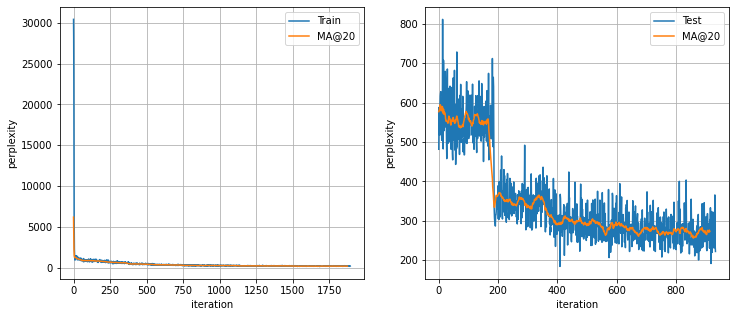

In [ ]:
oracle.cuda()

try:
    for epoch in range(5):
        for i, batch in enumerate(
                tqdm(train_dataloader, total=len(train_dataloader))
        ):
            (go, eos, mask) = map(lambda x: x.cuda(), batch[:-1])
            length = batch[-1]
            oracle.zero_grad()
            prediction = oracle(
                go, length
            ).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos) * mask.float()).sum()
            loss = loss / mask.sum()
            loss.backward()

            [x.grad.clamp_(-1, 1) for x in oracle.parameters()]

            optimizer.step()
            train_losses.append(np.exp(loss.cpu().item()))
        for i, batch in enumerate(
                tqdm(test_dataloader, total=len(test_dataloader))
        ):
            (go, eos, mask) = map(lambda x: x.cuda(), batch[:-1])
            length = batch[-1]
            prediction = oracle(
                go, length
            ).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos) * mask.float()).sum()
            loss = loss / mask.sum()
            test_losses.append(np.exp(loss.cpu().item()))
            
        clear_output(True)
        print('Epoch:', epoch)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train')
        plt.plot(moving_average(train_losses), label='MA@20')
        plt.xlabel('iteration')
        plt.ylabel('perplexity')
        plt.legend()
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(test_losses, label='Test')
        plt.plot(moving_average(test_losses), label='MA@20')
        plt.xlabel('iteration')
        plt.ylabel('perplexity')
        plt.legend()
        plt.grid()
        plt.show()
except KeyboardInterrupt:
    pass
finally:
    oracle.cpu();

In [ ]:
from itertools import product

params = list(product(
    [32, 64, 128, 256],  # embedding_size
    [64, 128, 256, 512],  # hidden_size
    [2, 4],  # layers
))

In [ ]:
best_loss = np.inf
best_param = None
best_losses = None

In [ ]:
for embedding_size, hidden_size, layers in tqdm(params):
    oracle = LSTMOracle(vocab.size,
                        embedding_size=embedding_size,
                        hidden_size=hidden_size, layers=layers)
    optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss(reduction='none')
    losses = []

    oracle.cuda()

    for epoch in range(1):
        for i, batch in enumerate(
                dataloader
                #tqdm(dataloader, total=len(dataloader))
        ):
            (go, eos, mask) = map(lambda x: x.cuda(), batch[:-1])
            length = batch[-1]
            oracle.zero_grad()
            prediction = oracle(
                go, length
            ).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos) * mask.float()).sum()
            loss = loss / mask.sum()
            loss.backward()

            [x.grad.clamp_(-1, 1) for x in oracle.parameters()]

            optimizer.step()
            losses.append(np.exp(loss.cpu().item()))
    if loss < best_loss:
        best_loss = loss
        best_param = (embedding_size, hidden_size, layers)
        best_losses = losses
    oracle.cpu()

In [ ]:
best_param, best_loss

((256, 128, 2), tensor(4.9907, device='cuda:0', grad_fn=<DivBackward0>))

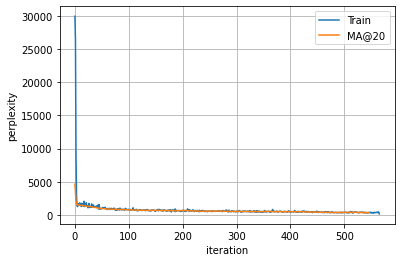

In [ ]:
plt.plot(best_losses, label='Train')
plt.plot(moving_average(best_losses), label='MA@20')
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.legend()
plt.grid()
plt.show()

In [ ]:
for _ in range(25):
    print(oracle.generate(vocab))
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


have ll be hear to sense in play in away pickup the as very that arguing and we democracy i happy a 

ally they pop life it old very neurons a a come <eos> 

turn guy deep as when <eos> 

everyone i job friend and not advised for financial matters d go tomorrow all they support of do our 

do 20 cities new talking not a to more and divide go our <eos> 

and exceeded must men looks facto piano of and but the give novel way job a one want asked worst and 

be because of now write not being footsteps being little when set write and knew mouth being stretch 

be goal <eos> 

through fun view who life m the an live he the the method scientific simply liberty rejected it another 

old the of m <eos> 

what is being lift live disavows because whether want take go i for to fun life or compete looks remedial 

i one is 11 are the old change and a it without subject m subject fun they like <eos> 

consider espionage <eos> 

believe do on for that i myself make are of of life own a we dream not c

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: